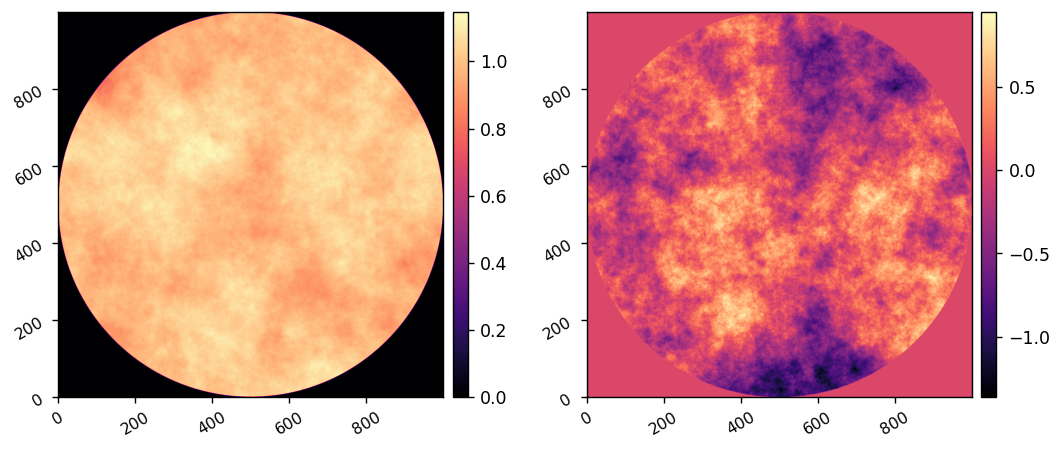

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

import scoobpsf
import scoobpsf.scoob_rmad as rmad
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina
import lina.adefc as adefc

wfe_amp = utils.load_fits('example_wfe_amp.fits')
wfe_phs = utils.load_fits('example_wfe_phs.fits')
WFE = wfe_amp * xp.exp(1j*wfe_phs)
imshow2(wfe_amp, wfe_phs)



# Test the forward model parameters.

Oversampling > 2x suggested for reliable results in Fresnel propagation.


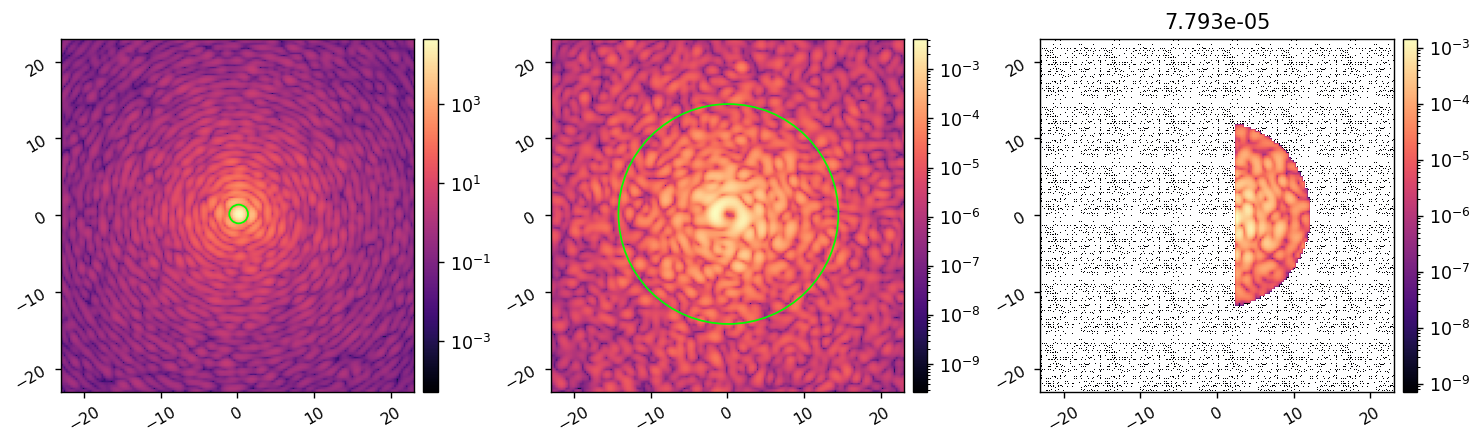

In [2]:
reload(rmad)
I = rmad.MODEL()
I.WFE = WFE
# I.flip_dm = 1

I.setattr('use_vortex', False)
ref_psf = I.snap()
I.setattr('Imax_ref', xp.max(ref_psf))
I.setattr('use_vortex', True)
ref_coro_im = I.snap()

iwa = 2.5
owa = 12
rot = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, irad=iwa, orad=owa, edge=iwa, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

psf_center = (I.psf_pixelscale_lamD/2, I.psf_pixelscale_lamD/2)
imshow3(ref_psf, ref_coro_im, ref_coro_im*control_mask, '', '', f'{mean_ni:.3e}',
        lognorm=True, pxscl=I.psf_pixelscale_lamD, 
        patches1=[Circle(psf_center, 1.22, fill=False, color='lime')], 
        patches2=[Circle(psf_center, I.control_rad, fill=False, color='lime')])

Oversampling > 2x suggested for reliable results in Fresnel propagation.


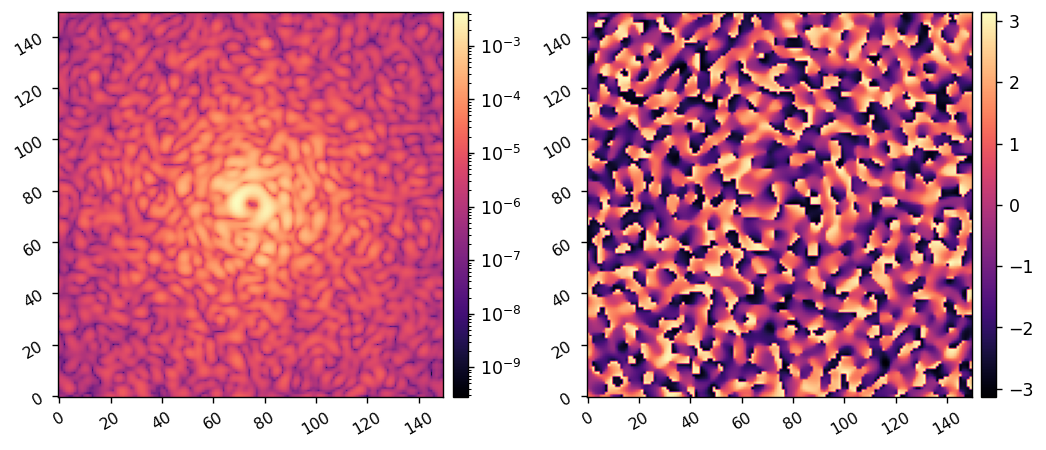

In [3]:
reload(rmad)
reload(scoobpsf.dm)
M = rmad.MODEL()
M.WFE = WFE

# M.flip_dm = 1

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

fpwf = M.forward(xp.zeros(M.dm_shape)[M.dm_mask], use_vortex=True)
imshow2(xp.abs(fpwf)**2, xp.angle(fpwf), lognorm1=True)


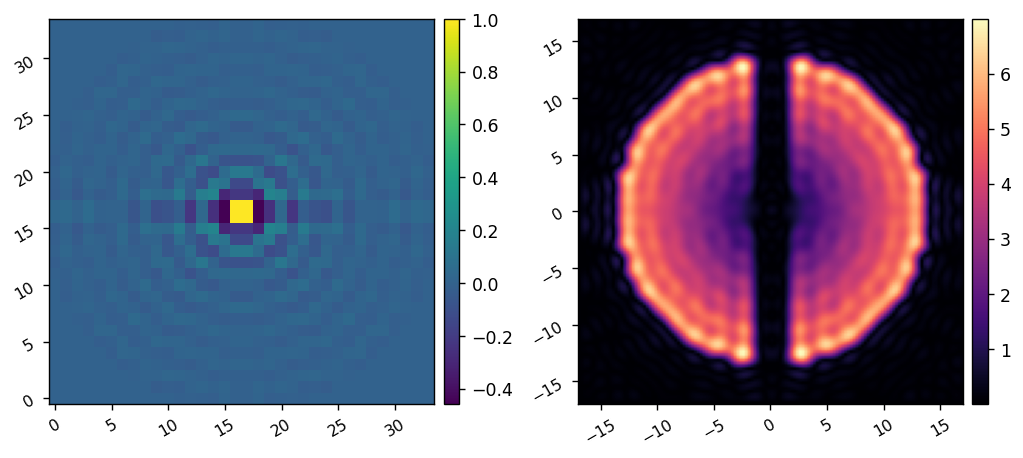

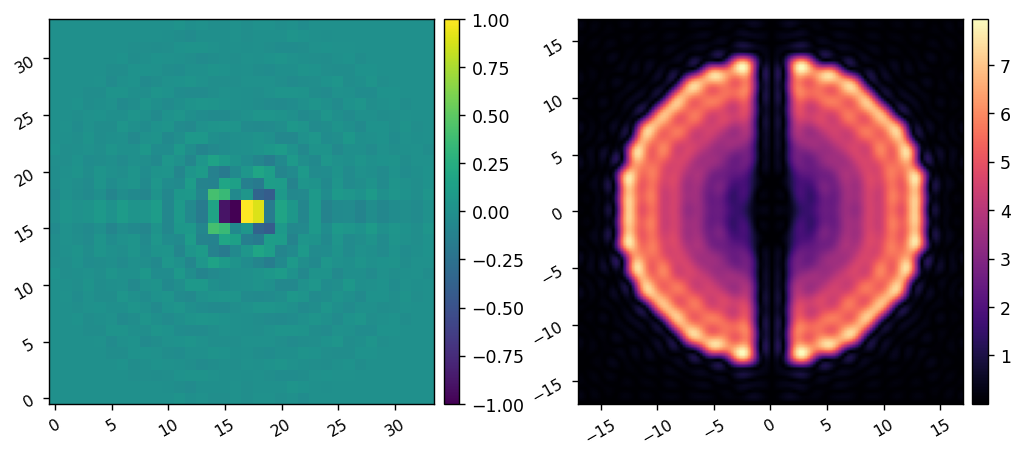

In [4]:
reload(lina.utils)

fourier_probes = lina.utils.create_fourier_probes(I.dm_mask, I.npsf, I.psf_pixelscale_lamD, iwa-0.5, owa+1, fourier_sampling=0.75, 
                                                    nprobes=2,
                                                    plot=True,
                                                    use_weighting=True
                                                    )

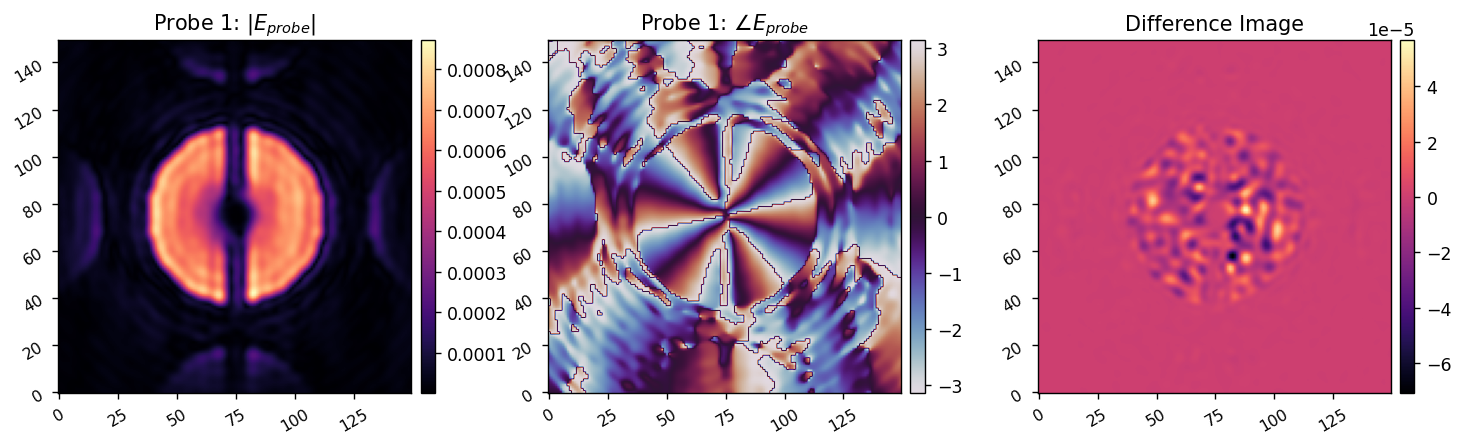

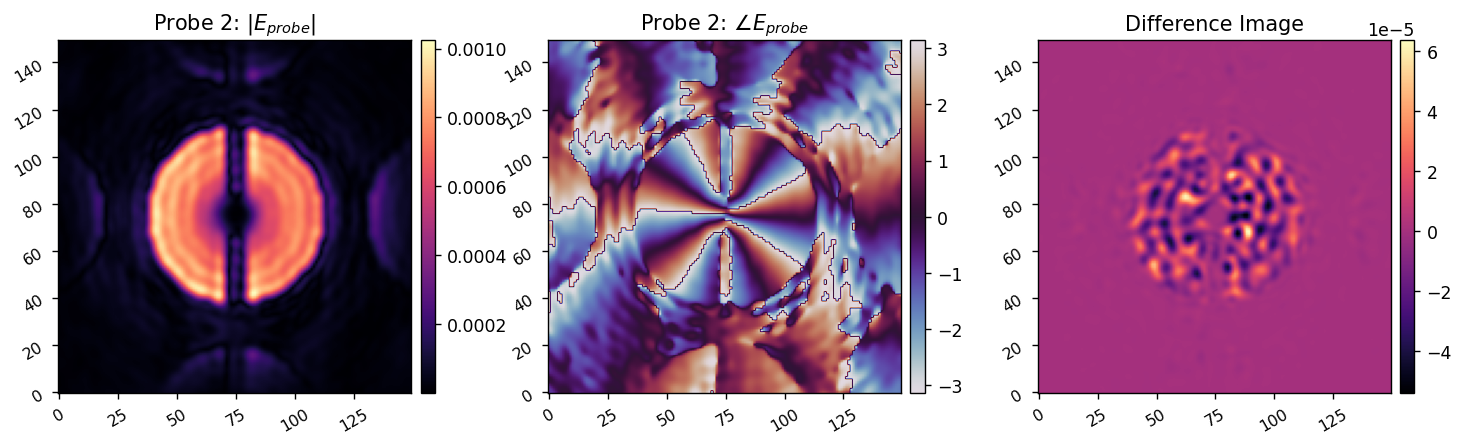

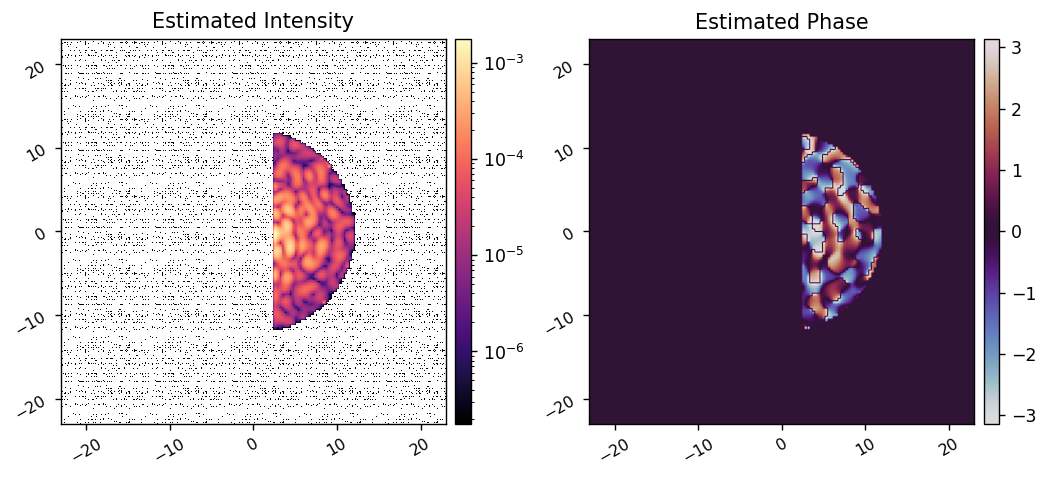

In [5]:
reload(adefc)

acts = np.zeros(I.Nacts)
# acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm(rmad.acts_to_command(acts, I.dm_mask))
E_pwp = adefc.run_pwp(I, M, I.get_dm()[M.dm_mask], control_mask, fourier_probes, 5e-9, plot=True)
I_pwp = xp.abs(E_pwp)**2
P_pwp = xp.angle(E_pwp)

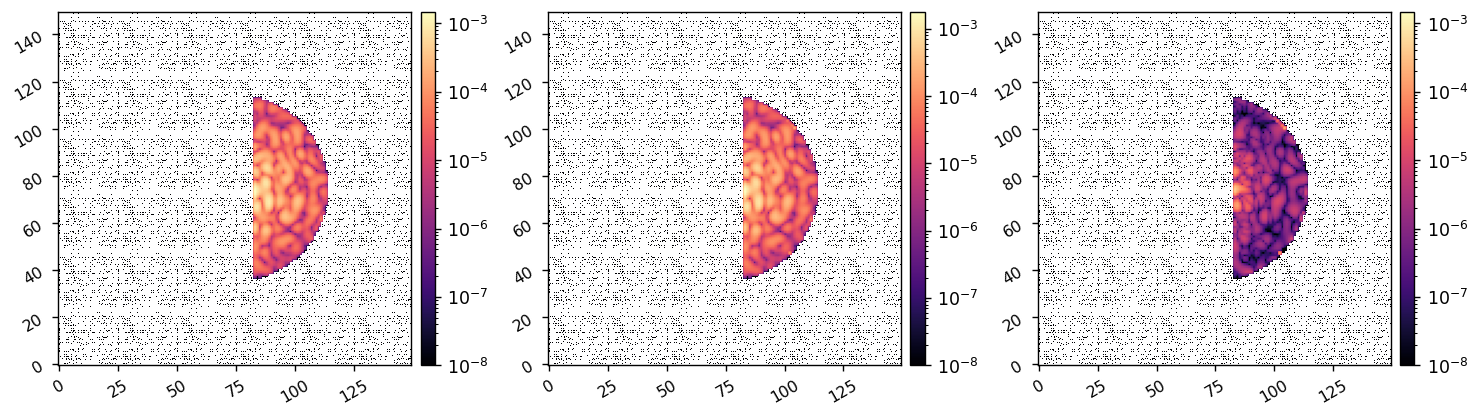

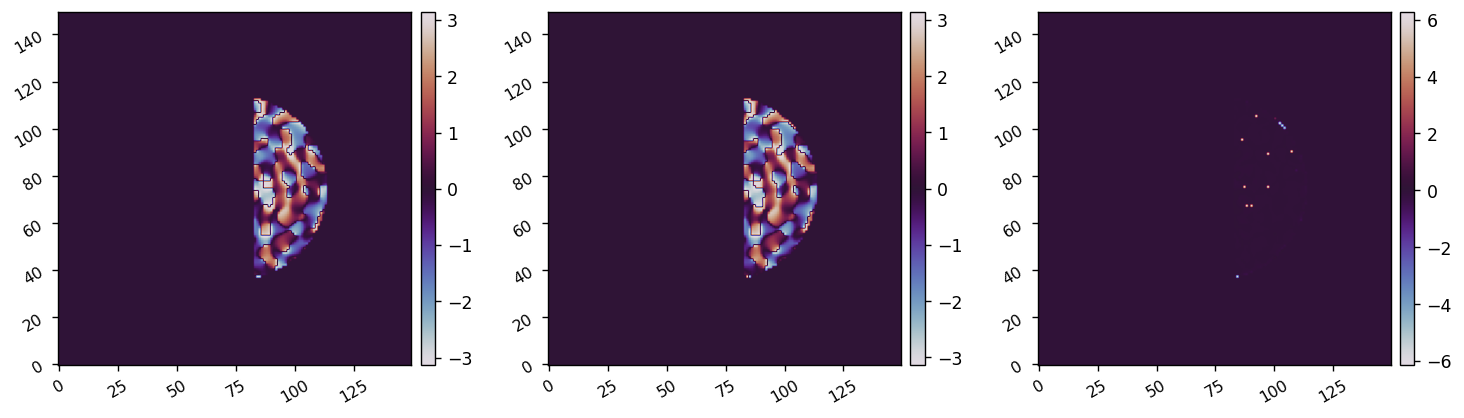

In [6]:
E_ex = I.calc_wf()
I_ex = xp.abs(E_ex)**2 * control_mask
P_ex = xp.angle(E_ex) * control_mask

I_diff = xp.abs(I_ex - I_pwp)
P_diff = P_ex - P_pwp
imshow3(I_ex, I_pwp, I_diff, lognorm=True, 
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8, vmax3=xp.max(I_ex))
imshow3(P_ex, P_pwp, P_diff, cmap1='twilight', cmap2='twilight', cmap3='twilight')